# Data Science Fellowship program exam

**Machine Learning - Assignment 2: Natural disasters dataset**

By: Jules Kuehn

Due: 2020-12-03, 6pm Eastern

## Task 1: Bag of words model

### Setup

In [21]:
%pip install -r ../requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [22]:
import sys
!{sys.executable} -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [66]:
from itertools import product
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from sklearn.metrics import f1_score

### Import data
Use Pandas to import the CSV to a Dataframe. For a larger dataset, I would use Spark for pre-processing steps.

In [24]:
train_df = pd.read_csv('../data/raw/train.csv')

### Preprocessing pipeline
Wrap preprocessing steps in a function for reproducibility.

Based on EDA in the previous notebook, I have added some manual (optional) steps before CountVectorizer's preprocessor:
* Replace numbers with "replaced_number"
* Replace "#" with "hashtag"
* Replace "@" with "at_symbol"
* Lemmatize with SpaCy NLP

Lowercasing and punctuation stripping are handled by CountVectorizer automatically.

The tweets appear to be entirely in English. Although there are a lot of spelling variations, I will leave these alone as misspelled words appear to be associated predominantly with non-disaster tweets.

Not implemented, but would be nice to try:
* Remove URLs, or
* Replace URLs with "url"

In [90]:
NLP = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def preprocess_texts(
    texts,
    replace_numbers=True,
    replace_mentions=True,
    replace_hashtags=True,
    lemmatize=True,
    remove_stopwords=True,
):
    """
    Preprocess texts for use in a bag-of-words model.
    Takes a list or Series of texts and returns a list of preprocessed texts.
    """
    if isinstance(texts, pd.Series):
        texts = texts.tolist()
    
    for i, text in enumerate(texts):
        if replace_numbers:
            # Replace any substring of digits using regex
            text = re.sub(r'\d+', ' replaced_number ', text)
        if replace_mentions:
            text = text.replace('@', ' at_symbol ')
        if replace_hashtags:
            text = text.replace('#', ' hashtag ')
        if lemmatize:
            if remove_stopwords:
                text = ' '.join(
                    [token.lemma_ for token in NLP(text) if not token.is_stop]
                )
            else:
                text = ' '.join([token.lemma_ for token in NLP(text)])
        texts[i] = text
    return texts


#### Limit Vectorizer vocabulary

Limit the vocabulary to words which are likely to be important in determining whether a tweet is disaster-related.

* Lemmatizing and removing stopwords (already done in pre-processing).
* Use CountVectorizer's max_df and min_df parameters.
* Manually remove words which are common in both disaster and non-disaster tweets.

Note that based on EDA, the dataset classes are fairly balanced so there is no need to rebalance here.

Not implemented, but would be nice to try:
* binary=True option on CountVectorizer

In [117]:
def create_vectorizer(
    non_disaster_tweets,
    disaster_tweets,
    initial_vocab='disaster',
    remove_n_common_words=5,
    min_df=5,
    max_features=None,
    strip_accents=None,
    lowercase=True,
    ):
    """
    Create a CountVectorizer for use in a bag-of-words model.
    Takes a list of non-disaster tweets and a list of disaster tweets.
    Optionally removes some common or uncommon words.
    Returns a CountVectorizer with the limited vocabulary.
    """

    # Get vocabulary from tweets (optionally removing uncommon words)
    if initial_vocab == 'disaster':
        initial_vocab_tweets = disaster_tweets
    else:
        initial_vocab_tweets = non_disaster_tweets + disaster_tweets

    transformer = CountVectorizer(
        strip_accents=strip_accents,
        lowercase=lowercase,
        min_df=min_df,
        max_features=max_features,
    ).fit(initial_vocab_tweets)

    if remove_n_common_words > 0:
        final_vocabulary = transformer.vocabulary_.copy()
        # Get the most common words in non-disaster tweets
        transformer = CountVectorizer(
            strip_accents=strip_accents,
            lowercase=lowercase,
            min_df=min_df,
        ).fit(non_disaster_tweets)
        bow = transformer.transform(list(non_disaster_tweets) + list(disaster_tweets))
        word_freqs = dict(zip(
            transformer.get_feature_names_out(),
            np.asarray(bow.sum(axis=0))[0]
        ))
        common_words = sorted(
            word_freqs.items(), key=lambda x: x[1], reverse=True
        )[:remove_n_common_words]

        # Remove most common non-disaster words from disaster tweets vocabulary
        for word in common_words:
            final_vocabulary.pop(word[0], None)

        # Create the final vectorizer with the limited vocabulary
        transformer = CountVectorizer(
            strip_accents=strip_accents,
            lowercase=lowercase,
            vocabulary=final_vocabulary.keys(),
        ).fit(disaster_tweets)
    
    return transformer


In [118]:
def print_vocab_details(transformer, texts):
    print(len(transformer.vocabulary_),
        'words in vocabulary')
    bow = transformer.transform(texts)
    word_freqs = dict(zip(
        transformer.get_feature_names_out(),
        np.asarray(bow.sum(axis=0))[0]
    ))

    common_words = sorted(
        word_freqs.items(), key=lambda x: x[1], reverse=True
    )[:20]
    print('Top 20 common words in vocabulary for these texts:')
    for i, word in enumerate(common_words):
        print(f'{i + 1}. {word[0]}: {word[1]}')


#### Create the vectorizer

Use the default values for the parameters for now.


In [119]:
train_df['processed_text'] = preprocess_texts(train_df['text'])

disaster_tweets = train_df[train_df['target'] == 1]['processed_text'].tolist()
non_disaster_tweets = train_df[train_df['target'] == 0]['processed_text'].tolist()

transformer = create_vectorizer(non_disaster_tweets, disaster_tweets)

print_vocab_details(transformer, disaster_tweets)

1228 words in vocabulary
Top 20 common words in vocabulary for these texts:
1. fire: 265
2. news: 150
3. kill: 149
4. amp: 135
5. https: 134
6. disaster: 122
7. california: 115
8. crash: 112
9. year: 112
10. suicide: 112
11. police: 109
12. people: 106
13. attack: 105
14. home: 104
15. family: 103
16. train: 101
17. like: 101
18. bomb: 100
19. hiroshima: 94
20. storm: 93


### Model training and evaluation

Note that I am not using the test data at this time. I am only using the training data while testing pre-processing hyperparameters.

(We will use the test data in the last task of this exam, to compare all models.)

I realize the assignment stated not to spend time tuning hyperparameters. I am operating on the assumption that what was meant was ML model hyperparameters. I am evaluating my **preprocessing hyperparameters** to ensure I have made the right decisions.

#### Evaluate pre-processing steps

Combine the above steps into a function which we can repeatedly call to evaluate f1 macro average score, which is suitable for this application.

In [124]:
def evaluate_preprocessing(
    train_df,
    replace_numbers=True,
    replace_mentions=True,
    replace_hashtags=True,
    lemmatize=False,
    remove_stopwords=True,
    strip_accents=None,
    lowercase=True,
    initial_vocab='disaster',
    remove_n_common_words=5,
    min_df=5,
    max_features=None,
    verbose=False,
    return_artifacts=False,
):
    # Preprocess texts before creating vectorizer
    train_df['processed_text'] = preprocess_texts(
        train_df['text'],
        replace_numbers=replace_numbers,
        replace_mentions=replace_mentions,
        replace_hashtags=replace_hashtags,
        lemmatize=lemmatize,
        remove_stopwords=remove_stopwords,
    )

    disaster_tweets = train_df[train_df['target'] == 1]['processed_text'].tolist()
    non_disaster_tweets = train_df[train_df['target'] == 0]['processed_text'].tolist()

    # Create vectorizer with limited vocabulary based on preprocessed texts
    transformer = create_vectorizer(
        non_disaster_tweets,
        disaster_tweets,
        initial_vocab=initial_vocab,
        remove_n_common_words=remove_n_common_words,
        min_df=min_df,
        max_features=max_features,
        strip_accents=strip_accents,
        lowercase=lowercase,
    )

    # Split the training data into training and validation sets
    X_train = transformer.transform(train_df['processed_text'])
    y_train = train_df['target']

    X_train, X_val, y_train, y_val = train_test_split(
        X_train,
        y_train,
        test_size=0.2,
        random_state=42,
    )

    # Create a basic bag of words model using a logistic regression classifier
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the validation set
    preds_val = model.predict(X_val)

    if verbose:
        # Display results on validation set
        print('LogisticRegression:')
        print(classification_report(y_val, preds_val))
        ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, cmap='Blues', normalize='true')
    
    if return_artifacts:
        return transformer, model, X_train, X_val, y_train, y_val

    # Return f1 macro average score
    return f1_score(y_val, preds_val, average='macro')


Best result:
 ({'lemmatize': False, 'remove_stopwords': False, 'strip_accents': 'ascii', 'lowercase': True}, 0.794162667094126)
LogisticRegression:
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       874
           1       0.81      0.71      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



0.794162667094126

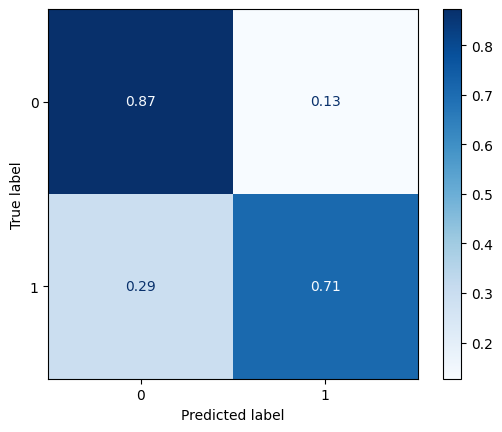

In [121]:
# Rather than do a complete grid search, we'll start with a few
# combinations of preprocessing steps
preprocessing_settings = [
    {'lemmatize': True}, # lemmatization (and stopword removal)
    {'lemmatize': True, 'remove_stopwords': False}, # lemmatization only
    # Otherwise, no lemmatization or stopword removal
    {'lemmatize': False, 'remove_stopwords': False},
    {'lemmatize': False, 'remove_stopwords': False, 'strip_accents': 'ascii', 'lowercase': True},
    {'lemmatize': False, 'remove_stopwords': False, 'strip_accents': 'ascii', 'lowercase': False},
]

results = []

for settings in preprocessing_settings:
    f1_macro = evaluate_preprocessing(train_df, **settings, verbose=False)
    results.append((settings, f1_macro))

best_result = max(results, key=lambda x: x[1])
print("Best result:\n", best_result)

evaluate_preprocessing(train_df, **best_result[0], verbose=True)

Best result:
 ({'initial_vocab': 'all', 'lemmatize': False, 'strip_accents': 'ascii', 'lowercase': True, 'replace_numbers': False, 'replace_mentions': False, 'replace_hashtags': False, 'remove_n_common_words': 5, 'min_df': 5, 'max_features': None}, 0.8046679384895338)
LogisticRegression:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       874
           1       0.81      0.73      0.77       649

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



0.8046679384895338

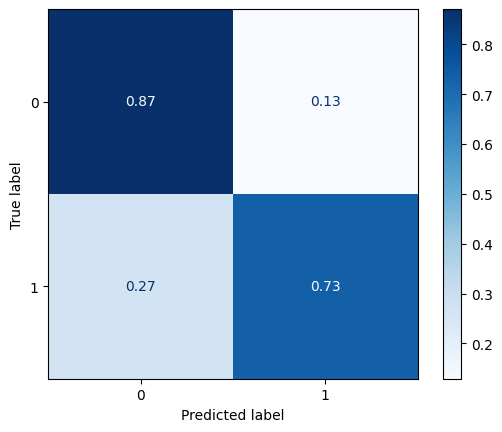

In [122]:
# Lemmatization is expensive, and doesn't seem to help
# Stripping accents does help, and so does lowercasing
# Keeping these options fixed...
# Let's try the other preprocessing combinations in a grid search
def grid_parameters(parameters):
    for params in product(*parameters.values()):
        yield dict(zip(parameters.keys(), params))

parameters = {
    'lemmatize': [False],
    'strip_accents': ['ascii'],
    'lowercase': [True],
    'initial_vocab': ['disaster', 'all'],
    'replace_numbers': [True, False],
    'replace_mentions': [True, False],
    'replace_hashtags': [True, False],
    'remove_n_common_words': [0, 5, 20],
    'min_df': [1, 5, 10],
    'max_features': [None, 500, 1000],
}

for settings in grid_parameters(parameters):
    f1_macro = evaluate_preprocessing(train_df, **settings, verbose=False)
    results.append((settings, f1_macro))

best_result = max(results, key=lambda x: x[1])
print("Best result:\n", best_result)

evaluate_preprocessing(train_df, **best_result[0], verbose=True)

In [ ]:
sorted(results, key=lambda x: x[1], reverse=True)

#### Summary of preprocessing results

The following preprocessing steps yielded the best results:
* Create a vocabulary based on all tweets, not just disaster tweets.
* Use CountVectorizer's built-in preprocessing to lowercase and strip ASCII punctuation.
* Remove the 5 most common words in non-disaster tweets.
* Remove words with less than 5 instances in the corpus.

Other preprocessing was evaluated, but decreased performance:
* Replacing numbers, @mentions or #hashtags
* Lemmatizing
* Removing stopwords
* Creating vocabulary based on disaster tweets only
* Limiting the size of the vocabulary to a fixed number (e.g. 1000)

### Explaining the model

An advantage of the bag of words + logistic regression model is its simplicity.

We can simply look up the model coefficients to determine feature importance:
* Which words contribute to a classification of "disaster" (1) or "non-disaster" (0)?

There is no need to scale the coefficients here since all the features are from the BoW.

In [169]:
transformer, model, X_train, X_val, y_train, y_val = evaluate_preprocessing(
    train_df, **best_result[0], return_artifacts=True
)

model_coefficients = pd.DataFrame(
   model.coef_.T,
   columns=['Coefficients'], index=transformer.get_feature_names_out()
)

sorted_words = model_coefficients.sort_values('Coefficients', ascending=False)
print('The following words have the highest positive coefficients (disaster):')
print(sorted_words.head(10).to_string())

print('\nThe following words have the most negative coefficients (non-disaster):')
print(sorted_words.tail(10)[::-1].to_string())

The following words have the highest positive coefficients (disaster):
            Coefficients
hiroshima       2.442601
wildfire        2.319744
earthquake      2.172741
fires           2.144314
derailment      2.070524
tornado         1.952837
massacre        1.893210
riots           1.889100
suicide         1.869176
bombing         1.836446

The following words have the most negative coefficients (non-disaster):
        Coefficients
ebay       -1.512722
full       -1.474744
better     -1.450262
blight     -1.395429
cake       -1.289771
upon       -1.285538
bags       -1.246251
likely     -1.221078
also       -1.190987
art        -1.183496


#### Explaining a single prediction

In [165]:
def predict_and_explain(tweet, model, transformer, settings):
    preprocessed_tweet = preprocess_texts(
        [tweet],
        replace_numbers=settings.pop('replace_numbers', True),
        replace_mentions=settings.pop('replace_mentions', True),
        replace_hashtags=settings.pop('replace_hashtags', True),
        lemmatize=settings.pop('lemmatize', True),
        remove_stopwords=settings.pop('remove_stopwords', True),
    )[0]
    bow = transformer.transform([preprocessed_tweet])
    prediction = model.predict(bow)[0]
    word_importance = []
    
    # Get words from bow
    words = transformer.get_feature_names_out()

    # Get model coefficients
    coefficients = model.coef_[0]

    # Get coefficients for words in the tweet
    for i, word in enumerate(words):
        if bow[0, i] > 0:
            word_importance.append((word, coefficients[i]))

    word_importance = sorted(word_importance, key=lambda x: x[1], reverse=True)

    print(f'Prediction: {"disaster" if prediction == 1 else "non-disaster"}\n')
    for word, coefficient in word_importance:
        print(f'{word}: {coefficient:.2f}')
    
    return prediction, word_importance


In [172]:
tweet = train_df['text'].sample(1).values[0]
print(tweet, '\n')

prediction, word_importance = predict_and_explain(tweet, model, transformer, best_result[0])


Latest : Trains derailment: 'It's the freakiest of freak accidents' - The Indian Express: The Indi... http://t.co/iLdbeJe225 #IndianNews 

Prediction: disaster

derailment: 2.07
train: 1.22
accident: 1.13
indian: 0.75
express: 0.51
late: 0.27
freakiest: 0.17
freak: 0.13
